In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

sns.set_style("whitegrid")

### Feature Engineering References:
https://www.propertyguru.com.sg/property-guides/ccr-ocr-rcr-region-singapore-ura-map-21045

In [9]:
# paths to all the csv files provided
train_path = './train.csv'
test_path = './test.csv'
properties_path = './properties.csv'
macrosPaths = [
    './cpi.csv',
    './interest.csv',
    './rentIndex.csv',
    './vacant.csv'
]

geo_path = './geo_attributes.csv'

# load csvs into padnas dataframe
## load train & test keys that contain unique identifier for each rows
train_keys = pd.read_csv(train_path).assign(train = 1)
test_keys = pd.read_csv(test_path).assign(train = 0).assign(price=pd.NA)
keys = pd.concat([train_keys, test_keys]) # fact table basically
keys = keys.rename(columns={ "contractDate": "date" })

## merge key with dimension tables to borrow the date information in key
properties = pd.read_csv(properties_path)
micro = pd.merge(properties, keys, on="property_key")

## loads all the macro files (other dimension tables like cpi and interest)
macros = []
for macrosPath in macrosPaths:
    df = pd.read_csv(macrosPath)
    df = df.rename(columns={ "Data Series": "date" })
    macros.append(df)
    
# load geo
geo = pd.read_csv(geo_path)

### Preprocessing `properties`

In [3]:
def preprocess_properties(properties):
    """
    preprocess properties table &
    feature engineering
    """
    
    # constants
    prop_type_dict = {
        'Apartment_RESIDENTIAL APARTMENTS': 'Public',
        'Terrace': 'Landed',
        'Detached': 'Landed',
        'Semi-detached': 'Landed',
        'Executive Condominium': 'EC',
        'Condominium': 'Condo',
        'Strata': 'Condo'
    }
    
    def _floorRange(floorRange, thresFloor=41):
        
        """
        some floorRange are too rare to be used as categorical variables
        Hence merging floorRange above the threshold into one
        
        Returns a new string categorical variable for floorRange
        """
        
        if floorRange != '-':
            floor_lower = int(re.search("(\d+)-", floorRange).groups()[0])
            
            if floor_lower >= thresFloor:
                floorRange = f"{thresFloor}-99"
                
        return floorRange
    
    def _floorRangeLower(floorRange):
        """
        Generates new columns `lower` based on the floor range by splitting
        the floor range string into two "01" and "05" if floorRange is
        "01-05" for instance.
        
        Returns the "01"
        """
        floor_str_split = floorRange.split("-")
            
        if floorRange == "-":
            floor_lower = 0
            
        else:
            if (floor_str_split[0] == 'B1') and (floor_str_split[1] == 'B5'):
                floor_lower = -1

            else:
                floor_lower = int(floor_str_split[0])

        # uses this features to generate new columns
        return floor_lower
        
    def _floorRangeUpper(floorRange):
        """
        Generates new columns `lower` based on the floor range by splitting
        the floor range string into two "01" and "05" if floorRange is
        "01-05" for instance.
        
        Returns the "05"
        """
        floor_str_split = floorRange.split("-")
            
        if floorRange == "-":
            floor_upper = 0
            
        else:
            if (floor_str_split[0] == 'B1') and (floor_str_split[1] == 'B5'):
                floor_upper = -5

            else:
                floor_upper = int(floor_str_split[1])

        # uses this features to generate new columns
        return floor_upper
        
    
    def _tenure(tenure):
        """
        generate new columns based on tenure type
        integer encode the categorical variable
        
        NOTES: Must be applied after the feature engineering!
        
        Returns integer encoded tenure type
        """
        
        if tenure == "Freehold":
            return 1
            
        else:
            return 0
    
    def _tenureLength(tenure):
        """
        Parse the tenure string by splitting into two separate string
        
        Returns the first string from the results which is the total years
        of leasehold
        """
        if tenure == "Freehold":
            return 1998 # doubles the maximum number of years of leasehold
        
        else:
            tenure_str_split = tenure.split(" yrs lease commencing from ")
            
            return int(tenure_str_split[0])
        
    def _tenureLeasePassed(tenure):
        """
        Calculates the total leased year by subtracting current date's year
        by the commence date of leasehold
        
        Returns an integer result
        """
        if tenure == "Freehold":
            return 0
        
        else:
            tenure_str_split = tenure.split(" yrs lease commencing from ")
            
            today_year = datetime.date.today().year
            
            return (today_year - int(tenure_str_split[1]))
    
    # floorRange preprocessing and feature engineering
    properties["floorRange"] = properties["floorRange"].apply(_floorRange)
    properties["floor_lower"] = properties["floorRange"].apply(_floorRangeLower)
    properties["floor_upper"] = properties["floorRange"].apply(_floorRangeUpper)
    
    # tenure preprocessing and feature engineering
    properties["tenure_length"] = properties["tenure"].apply(_tenureLength)
    properties["leased_passed"] = properties["tenure"].apply(_tenureLeasePassed)
    properties["tenure"] = properties["tenure"].apply(_tenure)
    
    # convert to datetime
    properties["date"] = pd.to_datetime(properties["date"])
    
    return micro
        

In [10]:
def preprocess_macros(cpi, interest, rentIndex, vacant):
    """
    four files are considered as macro-related files (economic macros):
        * cpi.csv
        * interest.csv
        * rentIndex.csv
        * vacant.csv
    """
    
    def yearQuarter2YearMonthly(df):
        """
        convert year-quarter in string format to monthly period
        """
        
        # repeat the first row for desired interpolation result
        df = pd.concat([df.head(0), df])
        df.at[0, "date"] = "2023 1Q "
        
        df["date"] = pd.to_datetime(
            (
                df["date"].str.replace(r"(\d+) (\d)Q ", r"\1-Q\2", regex=True)
            )
        ).dt.to_period('M')
        
        df = df.set_index("date").resample("M", convention="end").interpolate("linear")
        
        return df
    
    def yearMonthly2YearMonthly(df):
        """
        convert year-month in string format to monthly period
        """
        
        df["date"] = pd.to_datetime(df["date"], format="%Y %b ").dt.to_period('M')
        
        return df
    
    def mergeDfs(dfs, on):
        """
        join dataframe based on certain key
        """
        
        all_merged = dfs[0] # starting df
        
        for to_merge in dfs[1:]:
            all_merged = pd.merge(
                left=all_merged,
                right=to_merge,
                on=on,
                how="inner"
            )
            
        return all_merged
        
    # apply all the steps
    dfs = [
        yearMonthly2YearMonthly(cpi),
        yearMonthly2YearMonthly(interest),
        yearQuarter2YearMonthly(rentIndex),
        yearQuarter2YearMonthly(vacant)
    ]
    
    # integrate dataframes
    df = mergeDfs(dfs, on="date")
    
    # convert period of months (PeriodIndex) to datetime (Datetime)
    df["date"] = df["date"].dt.to_timestamp()
    
    # shift month by 3
    df["date"] = df["date"] + pd.DateOffset(months=+3)
    
    return df

In [11]:
# apply preprocessing steps to the micros and macros
micro = preprocess_properties(micro)
macro = preprocess_macros(*macros) # starred expression to unpack list

In [12]:
# merge both dataset
_merged = pd.merge(micro, macro, on="date", how="left")
merged = pd.merge(_merged, geo, on=['street', 'project', 'district'], how='left')
merged = merged.fillna(merged.mean(numeric_only=True))

### Feature Engineering

In [13]:
def feature_engineering(df):
    """
    This function focuses on the feature engineering for the dataset
    """
    
    new_df = df.copy(deep=True)
    
    # property type's dictionary
    prop_type_dict = {
        'Apartment_RESIDENTIAL APARTMENTS': 'Public',
        'Terrace': 'Landed',
        'Detached': 'Landed',
        'Semi-detached': 'Landed',
        'Executive Condominium': 'EC',
        'Condominium': 'Condo',
        'Strata': 'Condo'
    }
        
    def categorize_housing_type(propertyType, project, floorRange, price):
        if propertyType == "Apartment" and project == "RESIDENTIAL APARTMENTS" and price < 1500000:
            return "Public"
        
        elif propertyType in ["Terrace", "Detached", "Semi-detached"] or floorRange == '-':
            return "Landed"
        
        elif propertyType == "Executive Condominium":
            return "EC"
        
        elif re.search(r"Strata|Condominium|Apartment", propertyType) is not None:
            return "Condo"
        
        else:
            return "Other"
        
    def categorize_area(area):
        if area < 50:
            return 'Small'

        elif area >= 50 and area < 100:
            return "Medium"

        elif area >= 100 and area < 150:
            return "Medium Large"

        else:
            return "Large"
    
    # categorize housing type
    vectorized_categorizeHousingType = np.vectorize(categorize_housing_type)
    new_df['property_type_cat'] = vectorized_categorizeHousingType(
        new_df['propertyType'], 
        new_df['project'], 
        new_df['floorRange'], 
        new_df['price']
    )
    # map propertyType valeus to corresponding dictionary key and join with _ to create key for mapping to category
    new_df['prop_type_key'] = new_df['propertyType'] + '_' + new_df['project']
    new_df['property_type_cat'] = new_df['prop_type_key'].map(prop_type_dict).fillna(new_df['property_type_cat'])
    # drop prop_type_key
    new_df = new_df.drop('prop_type_key', axis=1)
    
    # categorizing area
    vectorized_categorizeArea = np.vectorize(categorize_area)
    new_df['area_cat'] = vectorized_categorizeArea(new_df['area'])
    
    return new_df

In [14]:
# feature engineering
merged = feature_engineering(merged)

In [15]:
# split dataset
train = merged[merged["train"] == 1]
test = merged[merged["train"] == 0]

### Modelling

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor as _RF
from sklearn.neural_network import MLPRegressor as _NN
from xgboost import XGBRegressor as _XGB
from lightgbm import LGBMRegressor as _LGBM
from catboost import CatBoostRegressor as _CR

### Models

In [93]:
class RF:
    def __init__(self, kwargs):
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        self.fitted = _RF(**self.kwargs).fit(X, y) # unpack dictionary as params list
        
    def predict(self, X):
        return self.fitted.predict(X)
    
    def feature_importances(self):
        return dict(zip(self.X.columns, self.fitted.feature_importances_))
    
class XGB:
    def __init__(self, kwargs):
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        self.fitted = _XGB(**self.kwargs).fit(X, y) # unpack dictionary as params list
        
    def predict(self, X):
        return self.fitted.predict(X)
    
    def feature_importances(self):
        return self.fitted.get_booster().get_score()
    
class LGBM:
    def __init__(self, kwargs):
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        self.fitted = _LGBM(**self.kwargs).fit(X, y) # unpack dictionary as params list
        
    def predict(self, X):
        return self.fitted.predict(X)
    
    def feature_importances(self):
        return dict(zip(self.X.columns, self.fitted.feature_importances_))

class NN:
    def __init__(self, kwargs):
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        self.fitted = _NN(**self.kwargs).fit(X, y) # unpack dictionary as params list
        
    def predict(self, X):
        return self.fitted.predict(X)
    
    def feature_importances(self):
        pass
    
class CR:
    def __init__(self, kwargs):
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        self.fitted = _CR(**self.kwargs).fit(X, y) # unpack dictionary as params list
        
    def predict(self, X):
        return self.fitted.predict(X)
    
    def feature_importances(self):
        pass
    
class HybridRegression:
    """
    Combines all the models above and predict using the mean of the predictions made by the three models
    """
    
    def __init__(self, kwargs):
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        
        self.fitted_cr = _CR(**self.kwargs["CR"].kwargs).fit(X, y) # unpack dictionary as params list
        self.fitted_lgbm = _LGBM(**self.kwargs["LGBM"].kwargs).fit(X, y)
        self.fitted_xgb = _XGB(**self.kwargs["XGB"].kwargs).fit(X, y)
        
    def predict(self, X):
        y_pred_cr = self.fitted_cr.predict(X)
        y_pred_lgbm = self.fitted_lgbm.predict(X)
        y_pred_xgb = self.fitted_xgb.predict(X)
        
        hybrid_pred = np.mean(np.vstack([y_pred_cr, y_pred_lgbm, y_pred_xgb]), axis=0)
        
        return hybrid_pred
    
    def feature_importances(self):
        # no feature importances for hybrid
        pass

In [40]:
class Models:
    def __init__(self, modelArgs):
        self.modelArgs = modelArgs
        self.model = {
            "RF": RF,
            "LGBM": LGBM,
            "XGB": XGB,
            "NN": NN,
            "CR": CR,
            "HR": HybridRegression
        }[self.modelArgs.model_name](self.modelArgs.kwargs)
        
    def train(self, X, y):
        print(f"Training {self.modelArgs.model_name}...")
        self.model.train(X, y)
        print("Training process done!")
        
    def predict(self, X):
        print(f"Predicting by {self.modelArgs.model_name}...")
        preds = self.model.predict(X)
        print("Prediction done!")
        
        return preds
    
    def evaluate(self, X, y):
        computeRMSE = lambda y, yHat : (((np.array(y) - np.array(yHat))**2).mean())**0.5
        
        preds = self.predict(X)
        rmse = computeRMSE(y, preds)
        
        plt.figure().set_figwidth(30)
        plt.plot(y - preds, "-b", label="true", alpha=0.3)
        plt.title(f"Model: ({self.modelArgs.model_name}): RMSE: {rmse}")
        plt.xlabel("Observations")
        plt.ylabel("Price")
        plt.show()
        
        # metrics plot to see how far the predictions is from the ground truth
#         plt.figure(figsize=(14, 8))
#         plt.title(f"Model: ({self.modelArgs.model_name}): RMSE: {rmse}")
#         plt.ylabel("Ground Truth")
#         plt.xlabel("Prediction")
#         scatterplot = sns.scatterplot(x=y, y=preds, alpha=0.3)
#         sns.lineplot(x=y, y=y, label="Line of best fit", color="yellow", ax=scatterplot)
#         plt.legend()
#         plt.show()
        
        return rmse
    
    def interpret(self):
        importances = self.model.feature_importances()
        importances = dict(sorted(importances.items(), key=lambda kv: kv[1], reverse=True))
        
        plt.figure().set_figwidth(30)
        plt.bar(importances.keys(), importances.values())
        plt.title(f"Model: ({self.modelArgs.__name__})")
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.xticks(rotation=-45, ha="left")
        plt.show()
        
        return importances

### Arguments

In [116]:
class RFArgs:
    """
    Hyperparameters for Random Forest model
    """
    
    model_name = "RF"
    kwargs = {
        "n_estimators": 900,
        "max_depth": 24,
        "min_samples_split": 10,
        "random_state": 42
    }

class XGBArgs:
    """
    Hyperparameters for XGBoost model
    """
    
    model_name = "XGB"
    kwargs = {
        "booster": "gbtree",
        "learning_rate": 0.05,
        "n_estimators": 256,
        "random_state": 42, 
        "min_child_weight": 2, 
        "subsample": 1, 
        "colsample_bytree": 0.8, 
        "reg_lambda": 0.45, 
        "reg_alpha": 0, 
        "gamma": 0.5,
        "max_leaves": 384
    }
    
class LGBMArgs:
    """
    Hyperparameters for LightGBM model
    """
    
    model_name = "LGBM"
    kwargs = {
        "learning_rate": 0.05,
        "random_state": 42,
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        "num_leaves": 384,
        "n_estimators": 256,
        "colsample_bytree": 0.8,
        "reg_lambda": 0.45
    }

class NNArgs:
    """
    Hyperparameters for Neural Network from sklearn
    """
    
    model_name = "NN"
    kwargs = {
        "hidden_layer_sizes": (512, 100),
        "activation": "relu",
        "solver": "adam",
#         "alpha": 0.1,
        "batch_size": 32,
        "learning_rate": 'constant',
        "learning_rate_init": 0.001,
        "max_iter": 500,
        "shuffle": True,
        "random_state": 42
    }

class CRArgs:
    """
    Hyperparameters for Catboost Regressor
    """
    
    model_name = "CR"
    kwargs = {
        "iterations": 1000,
        "depth": 6,
        "learning_rate": 0.05
    }
    
class HybridArgs:
    """
    Hyperparameters for Hybrid regression
    """
    
    model_name = "HR"
    kwargs = {
        "CR": CRArgs,
        "XGB": XGBArgs,
        "LGBM": LGBMArgs
    }
    
class Args:
    # hyperparameters for models
    modelArgs = {
        "RF": RFArgs,
        "XGB": XGBArgs,
        "LGBM": LGBMArgs,
        "NN": NNArgs,
        "CR": CRArgs,
        "HR": HybridArgs
    }
    
    # selected features' arguments
    featureArgs = {
        "area": float,
        "floorRange": str,
        "propertyType": str,
        "district": int,
        "property_type_cat": str,
        "area_cat": str,
        "typeOfArea": str,
        "tenure": int,
        "marketSegment": str,
        "price": float, # target
        "floor_lower": int,
        "floor_upper": int,
        "tenure_length": int,
        "leased_passed": int,
        "CPI": float,
        "InterestRate": float,
        "RentIndex": float,
        "Available": float,
        "Vacant": float,
        "lat": float,
        "lng": float,
        "num_schools_1km": int,
        "num_supermarkets_500m": int,
        "num_mrt_stations_500m": int,
        
        "train": int
    }
    

In [21]:
def oneHotEncoding(df, inputTypes):
    """
    This functions one-hot encode all categorical variables
    """
    
    df = df[inputTypes.keys()]
    df.astype(inputTypes)
    
    for columnName, inputType in inputTypes.items():
        if inputType == str:
            oneHot = pd.get_dummies(df[columnName], prefix=columnName)
            df = pd.concat([df, oneHot], axis=1).drop([columnName], axis=1)
            
    return df

def standardization(df, numeric_variables):
    """
    This functions standardize all continuous variables with standard scaler from sklearn
    """
    
    for numeric_variable in numeric_variables:
        # do not preprocessing the target
        scaler = StandardScaler()
        df[numeric_variable] = scaler.fit_transform(df[[numeric_variable]]).reshape(-1)
            
    return df

In [22]:
# preparing training set and testing set
df = pd.concat([train, test])
df = oneHotEncoding(df, Args.featureArgs)
df = standardization(df, ["area", "CPI", "InterestRate", "RentIndex", "Available", "Vacant", "lat", "lng"])

train_df = df[df["train"] == 1].drop("train", axis=1)
test_df = df[df["train"] == 0].drop("train", axis=1)

In [42]:
def predict_with_model(model_name):
    model = Models(Args.modelArgs[model_name])

    model.train(train_df.loc[:, train_df.columns != 'price'], train_df['price'])

    model.evaluate(train_df.loc[:, train_df.columns != 'price'], train_df['price'])

    preds = model.predict(test_df.loc[:, test_df.columns != 'price'])
    
    if model_name == "HR" or model_name == "NN" or model_name == "CR":
        return preds
    
    model.interpret()
    
    return preds

Training RF...
Training process done!
Predicting by RF...
Prediction done!


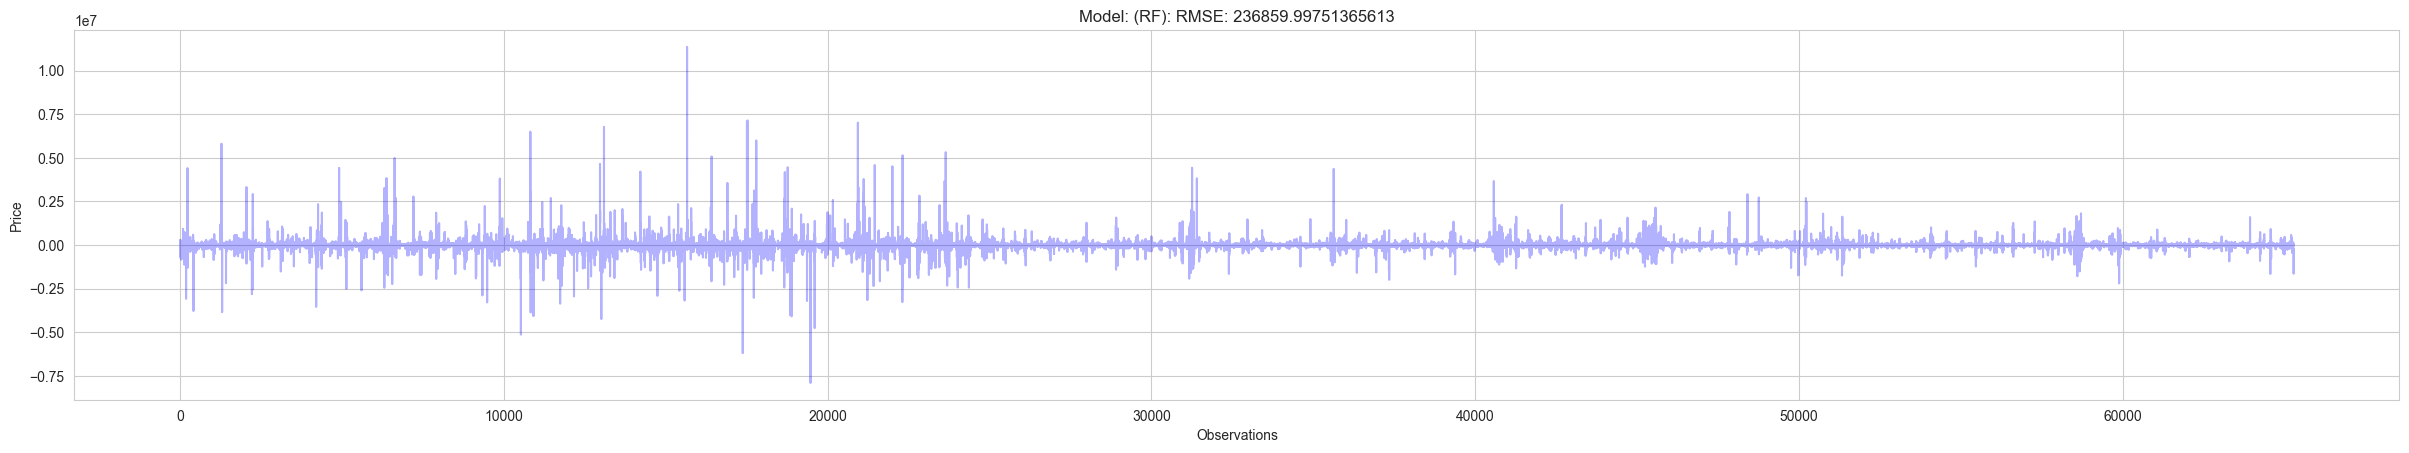

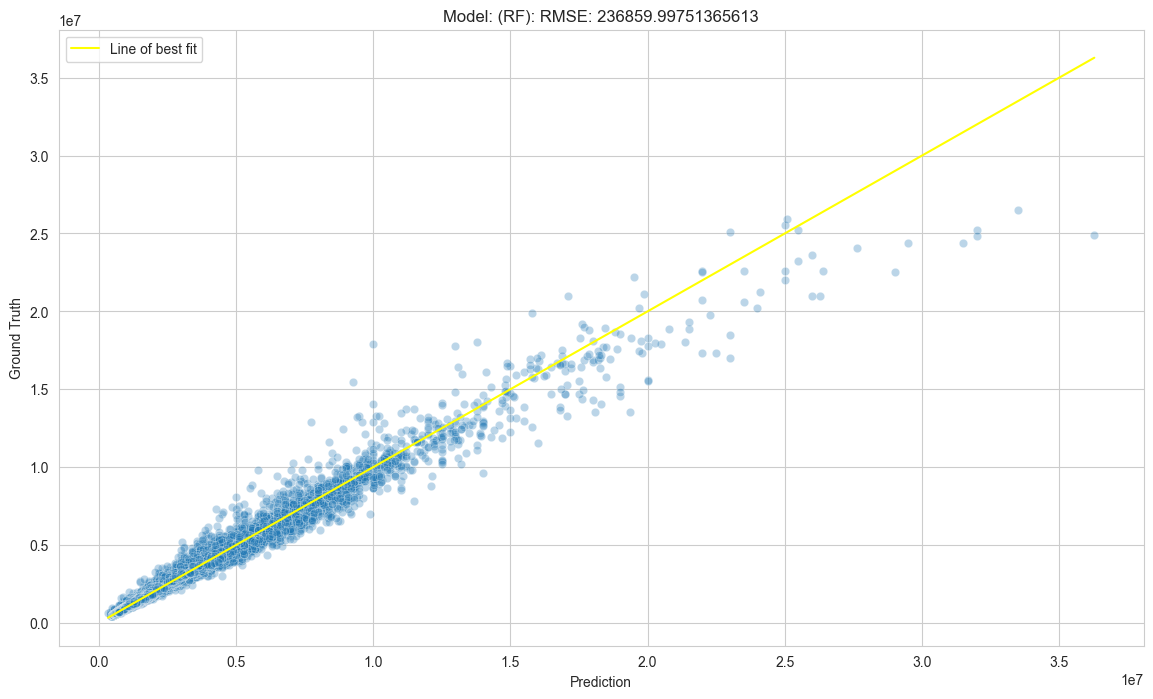

Predicting by RF...
Prediction done!


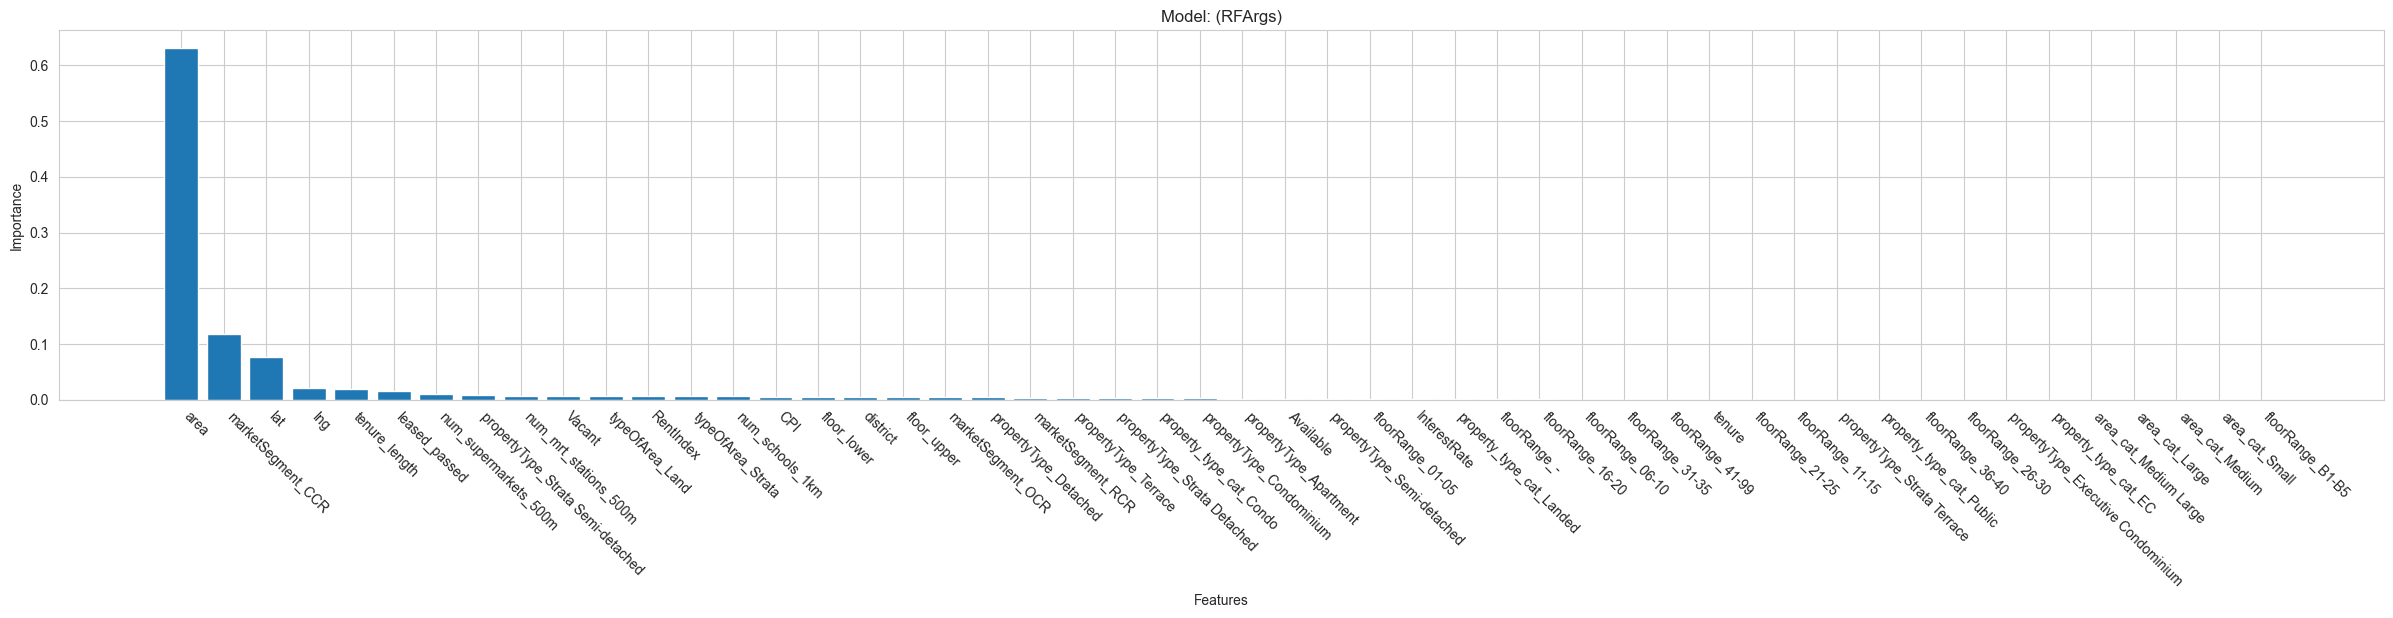

In [229]:
preds_rf = predict_with_model("RF")

Training NN...
Training process done!
Predicting by NN...
Prediction done!


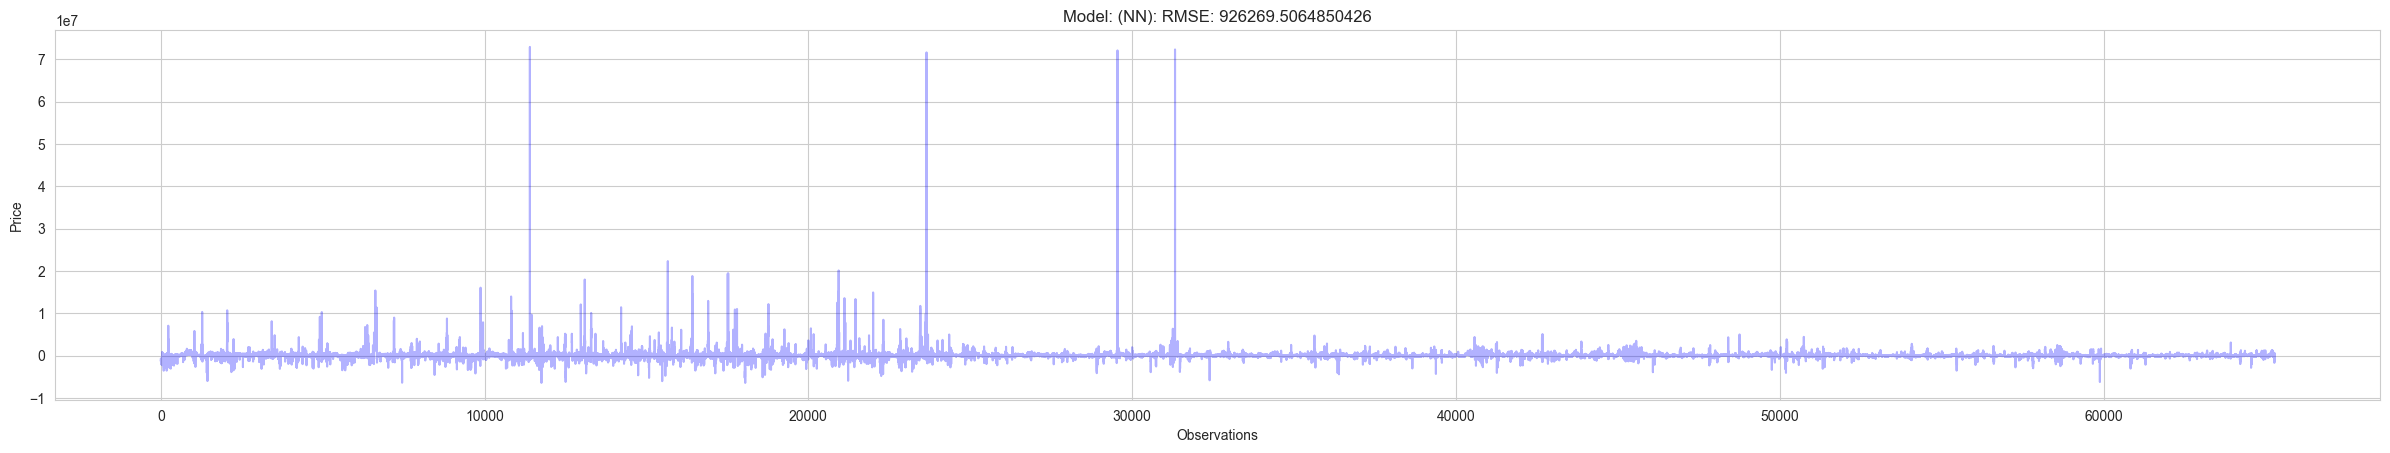

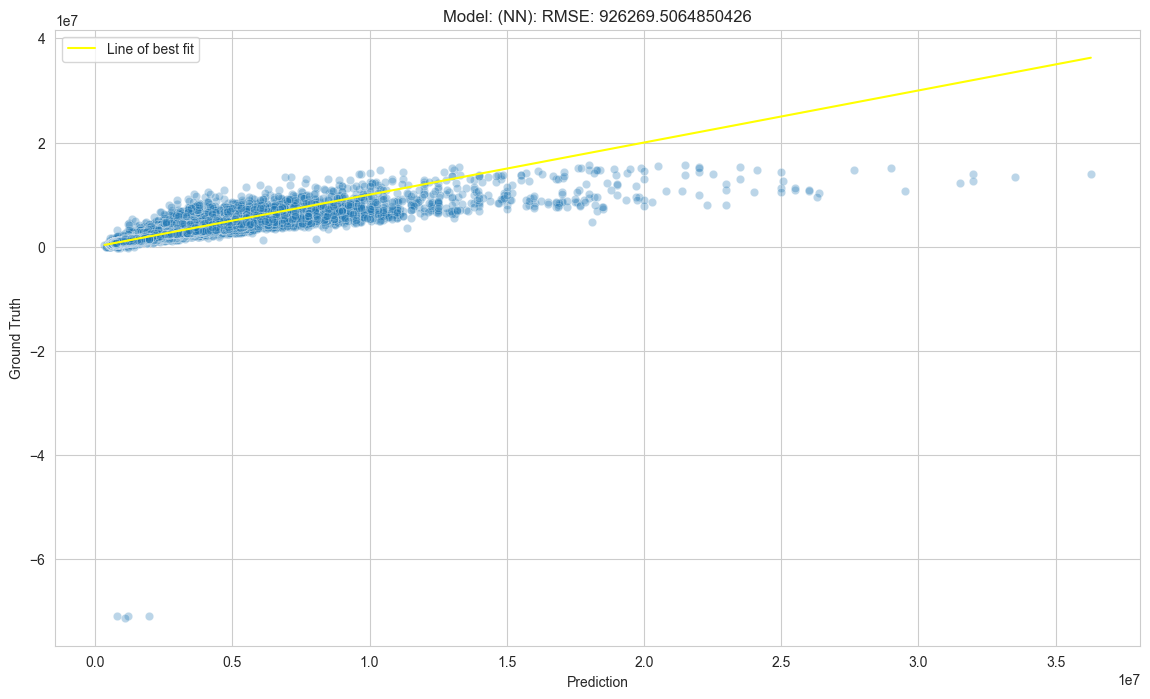

Predicting by NN...
Prediction done!


In [279]:
preds_nn = predict_with_model("NN")

Training LGBM...
Training process done!
Predicting by LGBM...
Prediction done!


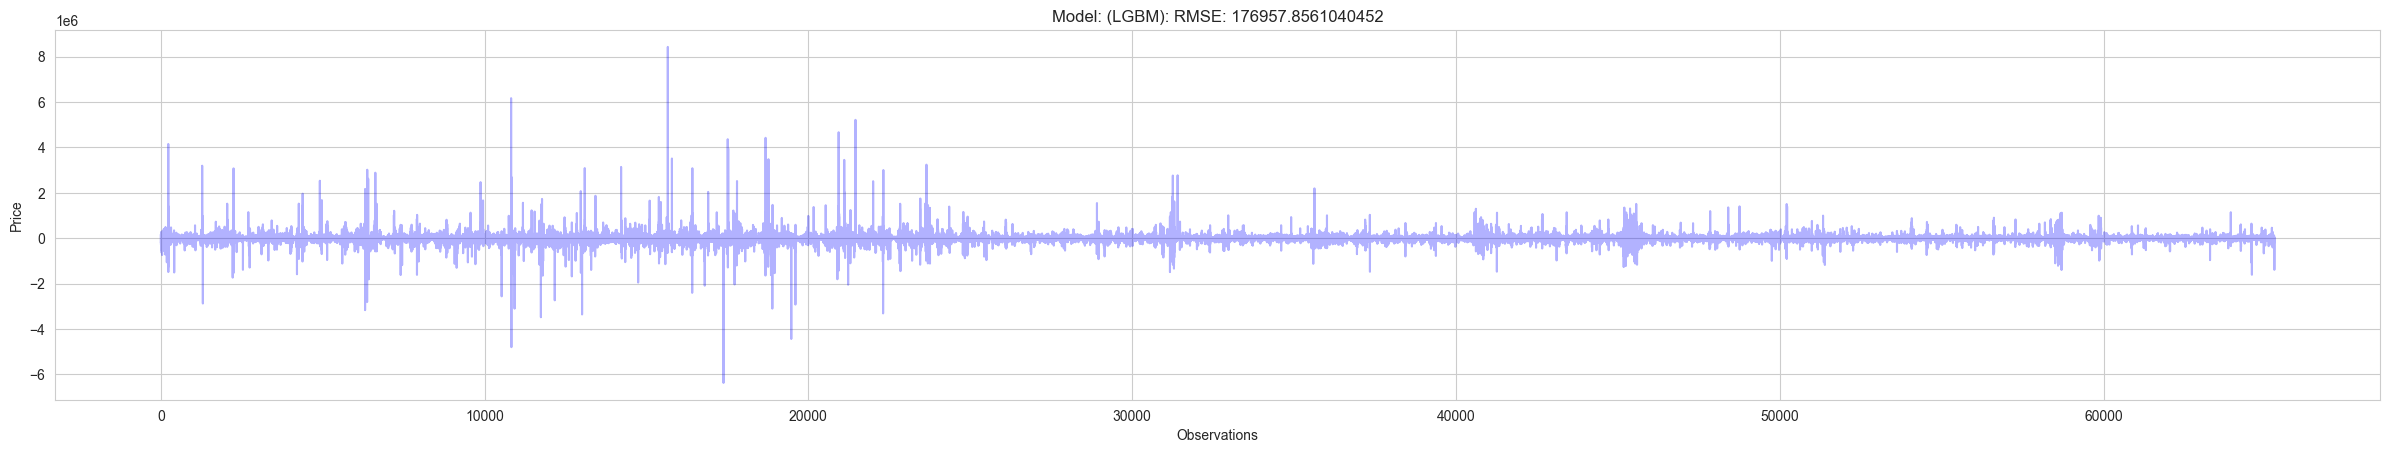

Predicting by LGBM...
Prediction done!


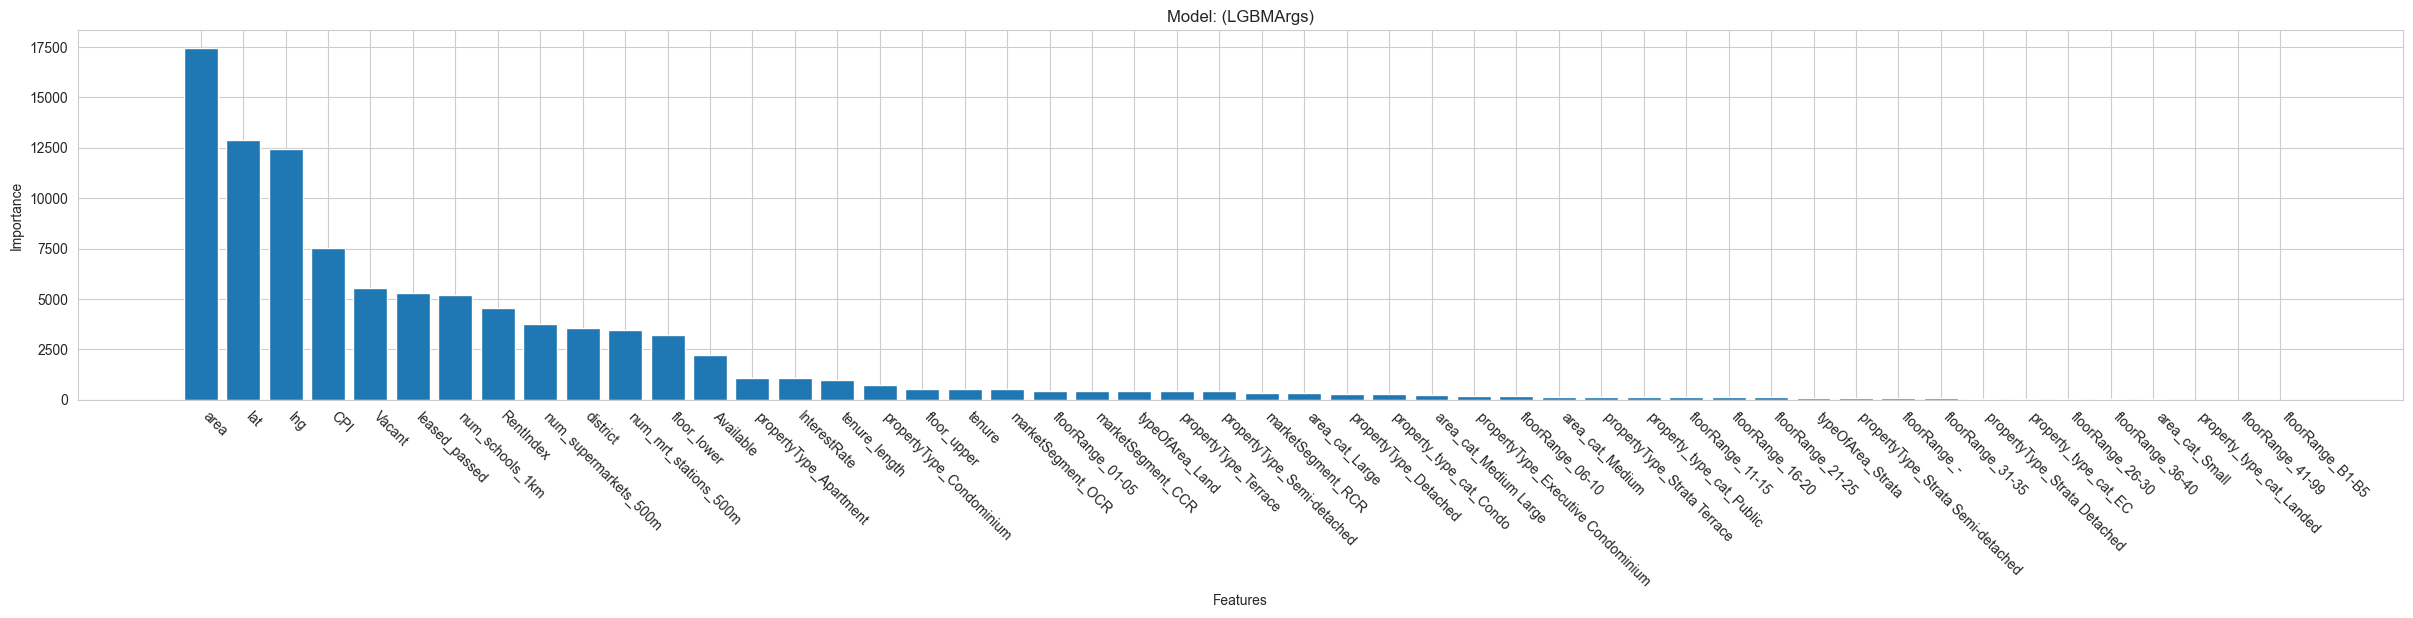

In [97]:
preds_lgbm = predict_with_model("LGBM")

Training XGB...
Training process done!
Predicting by XGB...
Prediction done!


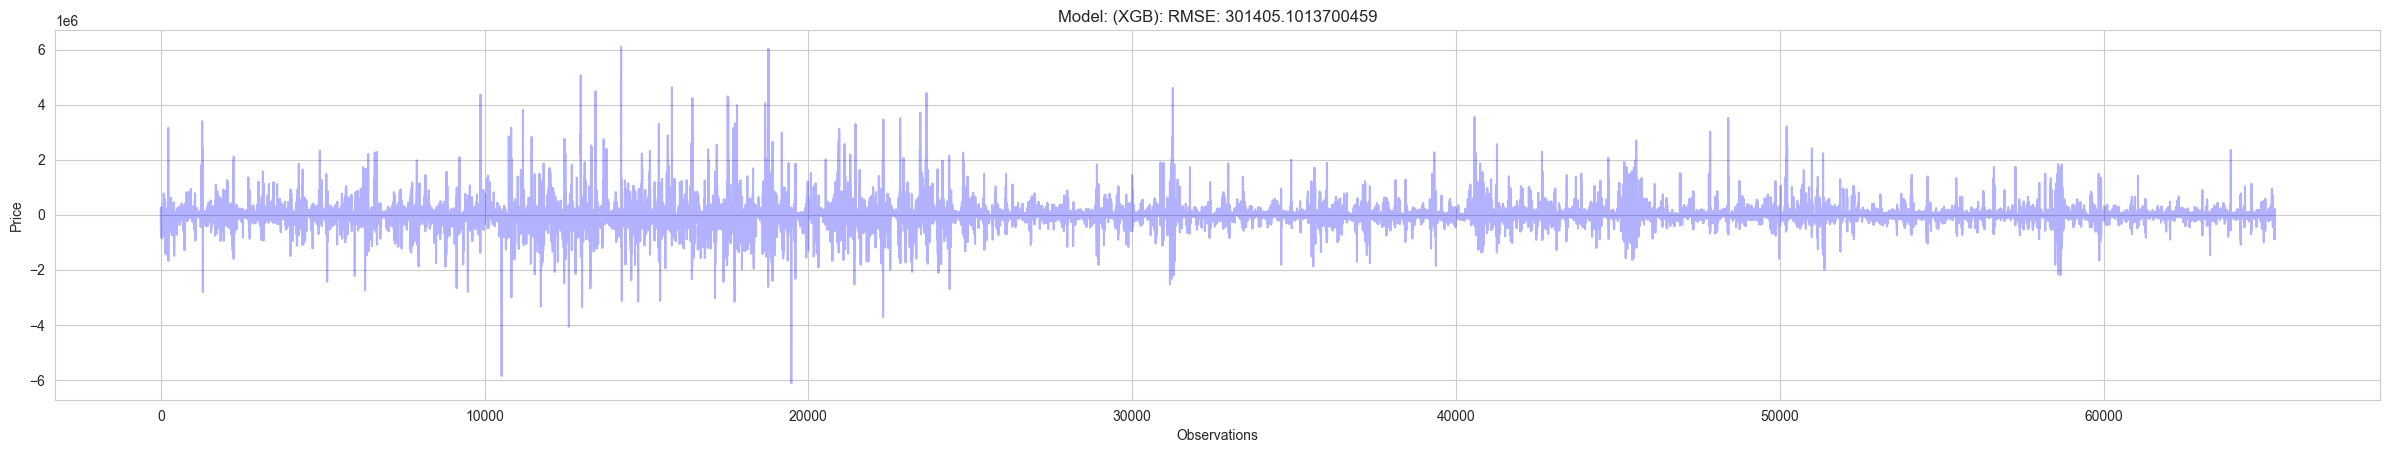

Predicting by XGB...
Prediction done!


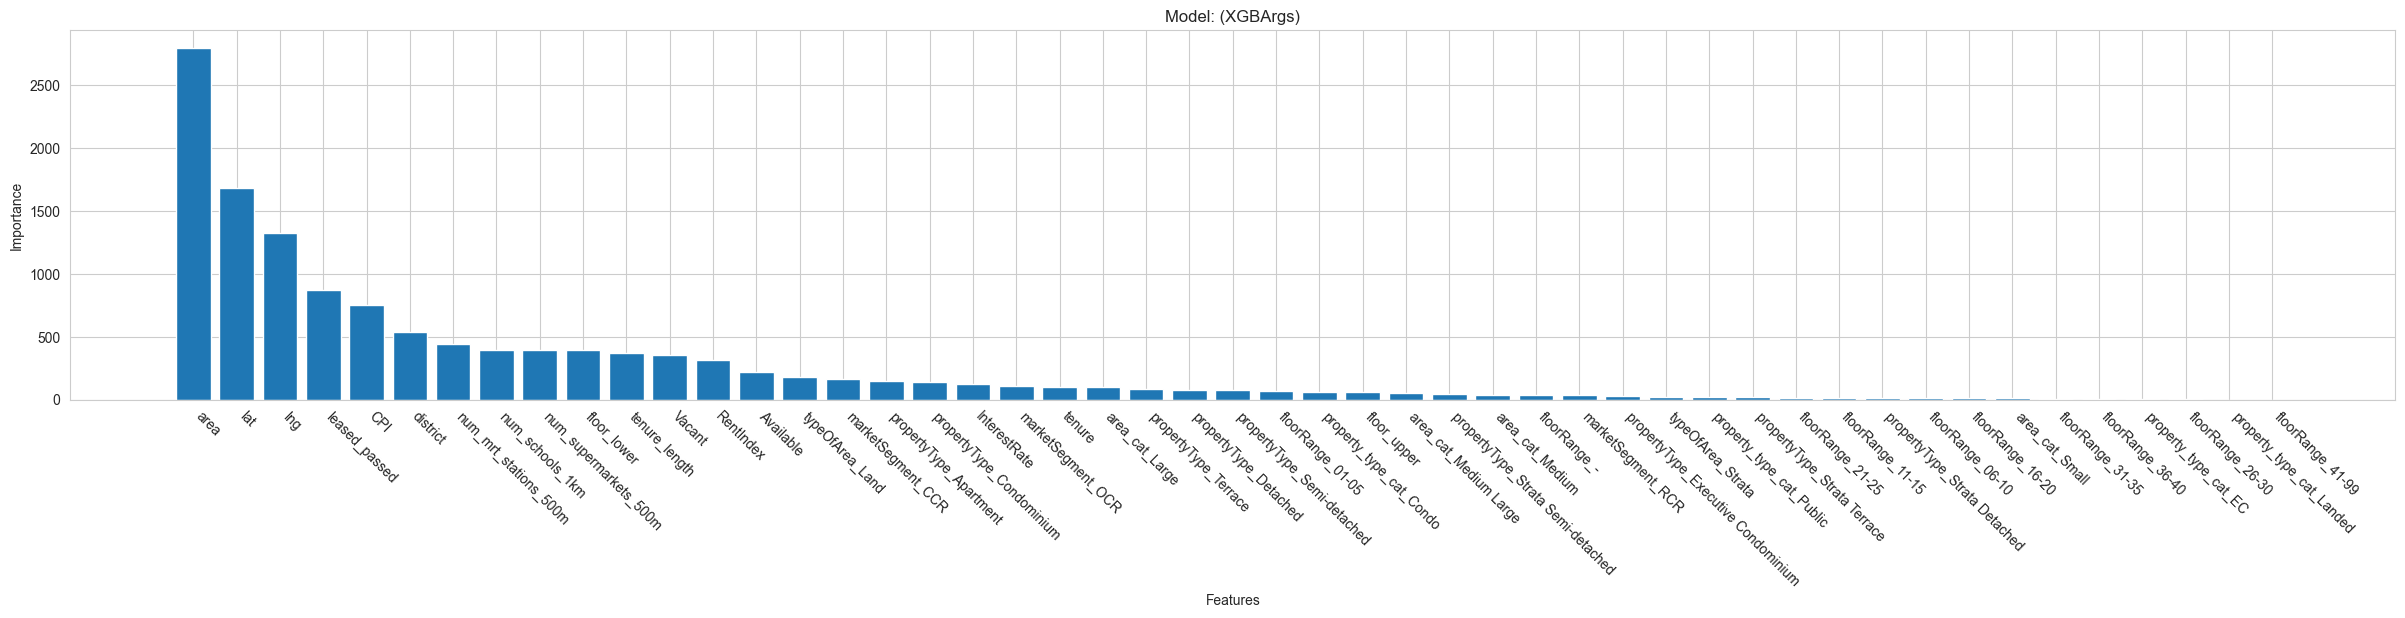

In [117]:
preds_xgb = predict_with_model("XGB")

Training HR...
0:	learn: 1591929.1771113	total: 5.05ms	remaining: 5.05s
1:	learn: 1536295.6969295	total: 8.82ms	remaining: 4.4s
2:	learn: 1483014.8542838	total: 12ms	remaining: 4s
3:	learn: 1433144.2115441	total: 15.1ms	remaining: 3.75s
4:	learn: 1385740.5982791	total: 18.5ms	remaining: 3.67s
5:	learn: 1343429.2359632	total: 21.9ms	remaining: 3.63s
6:	learn: 1299987.3394927	total: 25.1ms	remaining: 3.56s
7:	learn: 1259934.3134729	total: 28.4ms	remaining: 3.52s
8:	learn: 1222124.7305952	total: 31.5ms	remaining: 3.47s
9:	learn: 1186254.5428890	total: 34.6ms	remaining: 3.43s
10:	learn: 1152858.3512645	total: 37.7ms	remaining: 3.39s
11:	learn: 1121717.7994964	total: 40.9ms	remaining: 3.37s
12:	learn: 1091605.1756781	total: 44ms	remaining: 3.34s
13:	learn: 1064372.3216493	total: 47.2ms	remaining: 3.33s
14:	learn: 1038061.3762400	total: 50.3ms	remaining: 3.31s
15:	learn: 1013894.0468200	total: 53.4ms	remaining: 3.28s
16:	learn: 989917.5320985	total: 56.6ms	remaining: 3.27s
17:	learn: 967432.

171:	learn: 468144.2074481	total: 584ms	remaining: 2.81s
172:	learn: 467527.7086002	total: 588ms	remaining: 2.81s
173:	learn: 466785.5802978	total: 592ms	remaining: 2.81s
174:	learn: 465877.6635471	total: 595ms	remaining: 2.81s
175:	learn: 465233.4415482	total: 598ms	remaining: 2.8s
176:	learn: 464900.4323561	total: 601ms	remaining: 2.79s
177:	learn: 464630.2832619	total: 604ms	remaining: 2.79s
178:	learn: 464064.6676060	total: 608ms	remaining: 2.79s
179:	learn: 463779.4993143	total: 611ms	remaining: 2.78s
180:	learn: 463349.4255040	total: 614ms	remaining: 2.78s
181:	learn: 462693.7738281	total: 617ms	remaining: 2.77s
182:	learn: 462267.9979755	total: 620ms	remaining: 2.77s
183:	learn: 461569.2675750	total: 623ms	remaining: 2.76s
184:	learn: 461185.0108550	total: 626ms	remaining: 2.76s
185:	learn: 460741.4715825	total: 629ms	remaining: 2.75s
186:	learn: 460492.5483623	total: 632ms	remaining: 2.75s
187:	learn: 460180.7753988	total: 636ms	remaining: 2.75s
188:	learn: 459922.7438360	total

360:	learn: 401419.3768609	total: 1.2s	remaining: 2.12s
361:	learn: 401260.6916208	total: 1.2s	remaining: 2.11s
362:	learn: 401014.2832986	total: 1.2s	remaining: 2.11s
363:	learn: 400789.8528853	total: 1.21s	remaining: 2.11s
364:	learn: 400179.8714762	total: 1.21s	remaining: 2.1s
365:	learn: 399936.7577798	total: 1.21s	remaining: 2.1s
366:	learn: 399728.8390862	total: 1.22s	remaining: 2.1s
367:	learn: 399427.9057064	total: 1.22s	remaining: 2.1s
368:	learn: 399285.2119174	total: 1.22s	remaining: 2.09s
369:	learn: 399046.8898687	total: 1.23s	remaining: 2.09s
370:	learn: 398814.8861167	total: 1.23s	remaining: 2.08s
371:	learn: 398639.7079327	total: 1.23s	remaining: 2.08s
372:	learn: 398337.8064644	total: 1.24s	remaining: 2.08s
373:	learn: 398037.5683251	total: 1.24s	remaining: 2.07s
374:	learn: 397915.6653166	total: 1.24s	remaining: 2.07s
375:	learn: 397826.1566681	total: 1.24s	remaining: 2.06s
376:	learn: 397603.5290626	total: 1.25s	remaining: 2.06s
377:	learn: 397258.4142915	total: 1.25

537:	learn: 363235.1579249	total: 1.81s	remaining: 1.55s
538:	learn: 363071.8747648	total: 1.81s	remaining: 1.55s
539:	learn: 363011.7319053	total: 1.81s	remaining: 1.54s
540:	learn: 362860.9443599	total: 1.82s	remaining: 1.54s
541:	learn: 362682.2247338	total: 1.82s	remaining: 1.54s
542:	learn: 362600.1632326	total: 1.82s	remaining: 1.53s
543:	learn: 362500.8567745	total: 1.83s	remaining: 1.53s
544:	learn: 362083.0291818	total: 1.83s	remaining: 1.53s
545:	learn: 361924.6522870	total: 1.83s	remaining: 1.52s
546:	learn: 361631.8883778	total: 1.84s	remaining: 1.52s
547:	learn: 361460.4921790	total: 1.84s	remaining: 1.52s
548:	learn: 361309.7596882	total: 1.84s	remaining: 1.51s
549:	learn: 361159.0183534	total: 1.85s	remaining: 1.51s
550:	learn: 360910.2930793	total: 1.85s	remaining: 1.51s
551:	learn: 360696.4400831	total: 1.85s	remaining: 1.5s
552:	learn: 360577.1001079	total: 1.86s	remaining: 1.5s
553:	learn: 360429.2675993	total: 1.86s	remaining: 1.5s
554:	learn: 360256.1407536	total: 

711:	learn: 334742.0822808	total: 2.4s	remaining: 972ms
712:	learn: 334686.0115922	total: 2.4s	remaining: 968ms
713:	learn: 334424.1163656	total: 2.41s	remaining: 965ms
714:	learn: 334157.6409640	total: 2.41s	remaining: 962ms
715:	learn: 334043.8202196	total: 2.42s	remaining: 959ms
716:	learn: 333987.0561416	total: 2.42s	remaining: 955ms
717:	learn: 333821.0218465	total: 2.42s	remaining: 952ms
718:	learn: 333699.8417568	total: 2.43s	remaining: 949ms
719:	learn: 333540.3136253	total: 2.43s	remaining: 945ms
720:	learn: 333427.1387142	total: 2.43s	remaining: 942ms
721:	learn: 333333.6984495	total: 2.44s	remaining: 939ms
722:	learn: 333267.5089359	total: 2.44s	remaining: 935ms
723:	learn: 333062.6239610	total: 2.44s	remaining: 932ms
724:	learn: 332973.9675297	total: 2.45s	remaining: 928ms
725:	learn: 332901.6011312	total: 2.45s	remaining: 925ms
726:	learn: 332740.3289959	total: 2.45s	remaining: 922ms
727:	learn: 332403.2306023	total: 2.46s	remaining: 918ms
728:	learn: 332318.7357986	total:

869:	learn: 316632.3770623	total: 3.02s	remaining: 452ms
870:	learn: 316518.2205115	total: 3.03s	remaining: 448ms
871:	learn: 316377.2633746	total: 3.03s	remaining: 445ms
872:	learn: 316305.7864018	total: 3.03s	remaining: 441ms
873:	learn: 316255.6795278	total: 3.04s	remaining: 438ms
874:	learn: 316091.3875743	total: 3.04s	remaining: 435ms
875:	learn: 315996.7196324	total: 3.04s	remaining: 431ms
876:	learn: 315811.8084048	total: 3.05s	remaining: 428ms
877:	learn: 315756.5752533	total: 3.05s	remaining: 424ms
878:	learn: 315575.9888567	total: 3.06s	remaining: 421ms
879:	learn: 315510.5598745	total: 3.06s	remaining: 417ms
880:	learn: 315404.9015832	total: 3.06s	remaining: 414ms
881:	learn: 315350.2472251	total: 3.07s	remaining: 410ms
882:	learn: 315266.0547119	total: 3.07s	remaining: 407ms
883:	learn: 315185.6489368	total: 3.07s	remaining: 403ms
884:	learn: 314995.4163164	total: 3.08s	remaining: 400ms
885:	learn: 314928.9502199	total: 3.08s	remaining: 396ms
886:	learn: 314872.7168887	tota

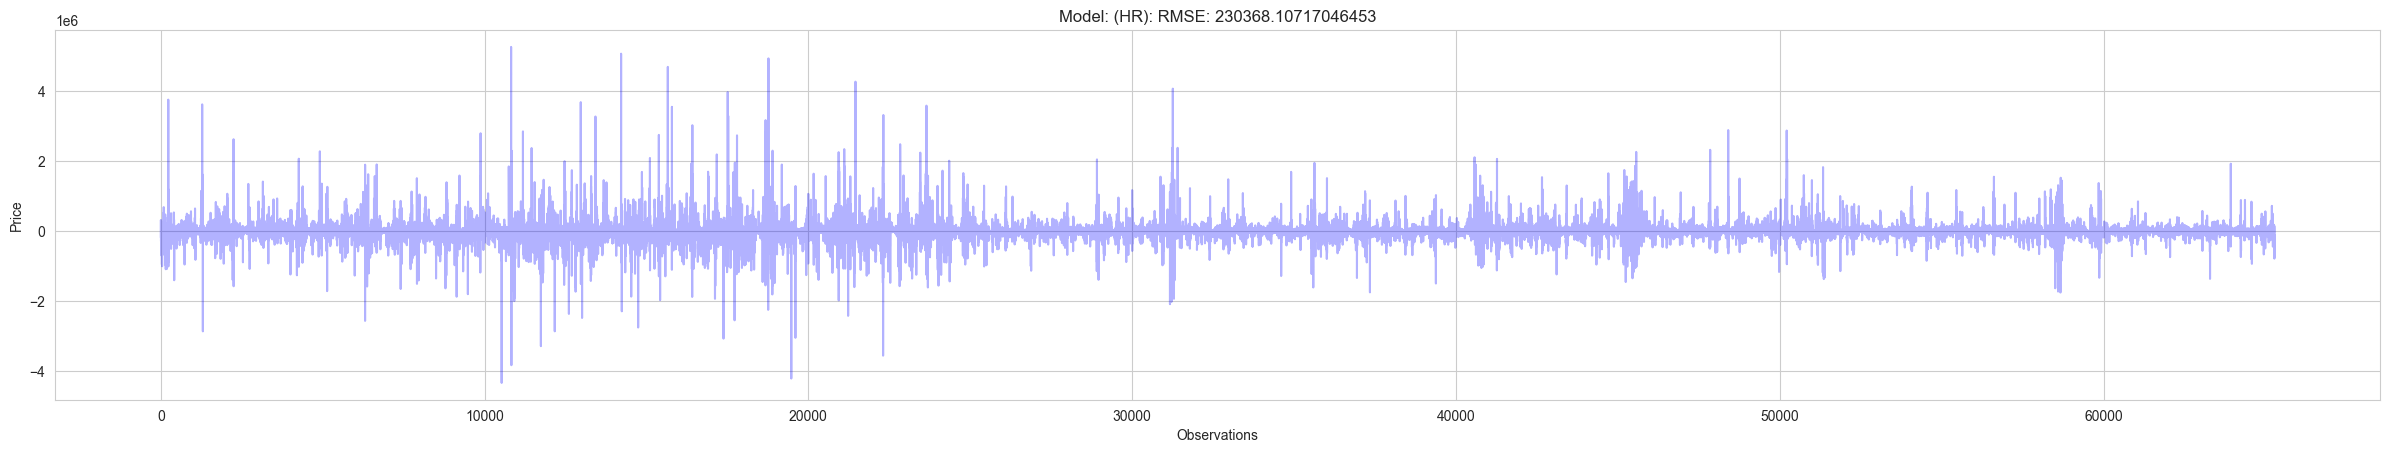

Predicting by HR...
Prediction done!


In [94]:
preds_hr = predict_with_model("HR")

Training CR...
0:	learn: 1591929.1771113	total: 3.62ms	remaining: 3.61s
1:	learn: 1536295.6969295	total: 7.06ms	remaining: 3.52s
2:	learn: 1483014.8542838	total: 10.2ms	remaining: 3.38s
3:	learn: 1433144.2115441	total: 13.3ms	remaining: 3.31s
4:	learn: 1385740.5982791	total: 16.4ms	remaining: 3.27s
5:	learn: 1343429.2359632	total: 19.6ms	remaining: 3.25s
6:	learn: 1299987.3394927	total: 22.7ms	remaining: 3.22s
7:	learn: 1259934.3134729	total: 25.8ms	remaining: 3.2s
8:	learn: 1222124.7305952	total: 28.9ms	remaining: 3.19s
9:	learn: 1186254.5428890	total: 32.2ms	remaining: 3.19s
10:	learn: 1152858.3512645	total: 35.4ms	remaining: 3.18s
11:	learn: 1121717.7994964	total: 38.5ms	remaining: 3.17s
12:	learn: 1091605.1756781	total: 41.8ms	remaining: 3.17s
13:	learn: 1064372.3216493	total: 45.1ms	remaining: 3.17s
14:	learn: 1038061.3762400	total: 48.4ms	remaining: 3.18s
15:	learn: 1013894.0468200	total: 51.6ms	remaining: 3.17s
16:	learn: 989917.5320985	total: 54.9ms	remaining: 3.17s
17:	learn: 

174:	learn: 465877.6635471	total: 577ms	remaining: 2.72s
175:	learn: 465233.4415482	total: 580ms	remaining: 2.71s
176:	learn: 464900.4323561	total: 583ms	remaining: 2.71s
177:	learn: 464630.2832619	total: 587ms	remaining: 2.71s
178:	learn: 464064.6676060	total: 591ms	remaining: 2.71s
179:	learn: 463779.4993143	total: 594ms	remaining: 2.7s
180:	learn: 463349.4255040	total: 597ms	remaining: 2.7s
181:	learn: 462693.7738281	total: 600ms	remaining: 2.7s
182:	learn: 462267.9979755	total: 603ms	remaining: 2.69s
183:	learn: 461569.2675750	total: 606ms	remaining: 2.69s
184:	learn: 461185.0108550	total: 610ms	remaining: 2.69s
185:	learn: 460741.4715825	total: 613ms	remaining: 2.68s
186:	learn: 460492.5483623	total: 616ms	remaining: 2.68s
187:	learn: 460180.7753988	total: 619ms	remaining: 2.67s
188:	learn: 459922.7438360	total: 623ms	remaining: 2.67s
189:	learn: 459458.5932514	total: 626ms	remaining: 2.67s
190:	learn: 459078.6526003	total: 629ms	remaining: 2.66s
191:	learn: 458684.0330334	total: 

342:	learn: 406738.2159300	total: 1.17s	remaining: 2.25s
343:	learn: 406239.0754381	total: 1.18s	remaining: 2.24s
344:	learn: 405774.8997108	total: 1.18s	remaining: 2.24s
345:	learn: 405623.9450288	total: 1.18s	remaining: 2.24s
346:	learn: 405237.4787934	total: 1.19s	remaining: 2.23s
347:	learn: 404956.2636118	total: 1.19s	remaining: 2.23s
348:	learn: 404766.1755958	total: 1.19s	remaining: 2.23s
349:	learn: 404605.6804856	total: 1.2s	remaining: 2.23s
350:	learn: 404364.2053946	total: 1.2s	remaining: 2.22s
351:	learn: 404177.6292523	total: 1.2s	remaining: 2.22s
352:	learn: 403925.9135150	total: 1.21s	remaining: 2.21s
353:	learn: 403687.5418881	total: 1.21s	remaining: 2.21s
354:	learn: 403313.6677564	total: 1.22s	remaining: 2.21s
355:	learn: 403130.8342507	total: 1.22s	remaining: 2.2s
356:	learn: 402962.9916341	total: 1.22s	remaining: 2.2s
357:	learn: 402545.9782203	total: 1.23s	remaining: 2.2s
358:	learn: 402243.6809354	total: 1.23s	remaining: 2.19s
359:	learn: 401904.4011663	total: 1.2

520:	learn: 366302.4024050	total: 1.77s	remaining: 1.63s
521:	learn: 366147.2499417	total: 1.78s	remaining: 1.63s
522:	learn: 365847.3463952	total: 1.78s	remaining: 1.62s
523:	learn: 365772.0808196	total: 1.78s	remaining: 1.62s
524:	learn: 365607.0267913	total: 1.79s	remaining: 1.62s
525:	learn: 365461.8510031	total: 1.79s	remaining: 1.61s
526:	learn: 365375.0672499	total: 1.79s	remaining: 1.61s
527:	learn: 365216.8952253	total: 1.8s	remaining: 1.61s
528:	learn: 365151.3535613	total: 1.8s	remaining: 1.6s
529:	learn: 365041.6945193	total: 1.8s	remaining: 1.6s
530:	learn: 364836.1026473	total: 1.81s	remaining: 1.6s
531:	learn: 364473.6560430	total: 1.81s	remaining: 1.59s
532:	learn: 364308.4965638	total: 1.81s	remaining: 1.59s
533:	learn: 364260.9470759	total: 1.82s	remaining: 1.59s
534:	learn: 363978.9948610	total: 1.82s	remaining: 1.58s
535:	learn: 363647.3465771	total: 1.82s	remaining: 1.58s
536:	learn: 363379.3208012	total: 1.83s	remaining: 1.58s
537:	learn: 363235.1579249	total: 1.8

678:	learn: 339364.9695136	total: 2.37s	remaining: 1.12s
679:	learn: 339247.3676216	total: 2.38s	remaining: 1.12s
680:	learn: 339080.7340357	total: 2.38s	remaining: 1.11s
681:	learn: 338976.8411869	total: 2.38s	remaining: 1.11s
682:	learn: 338902.3893283	total: 2.39s	remaining: 1.11s
683:	learn: 338633.7409464	total: 2.39s	remaining: 1.1s
684:	learn: 338521.8880058	total: 2.4s	remaining: 1.1s
685:	learn: 338355.7614562	total: 2.4s	remaining: 1.1s
686:	learn: 338264.0975057	total: 2.4s	remaining: 1.09s
687:	learn: 338044.7825122	total: 2.41s	remaining: 1.09s
688:	learn: 337910.3835435	total: 2.41s	remaining: 1.09s
689:	learn: 337800.4892431	total: 2.42s	remaining: 1.08s
690:	learn: 337665.2053433	total: 2.42s	remaining: 1.08s
691:	learn: 337572.5644760	total: 2.42s	remaining: 1.08s
692:	learn: 337423.1991760	total: 2.43s	remaining: 1.07s
693:	learn: 337327.6007429	total: 2.43s	remaining: 1.07s
694:	learn: 337264.6504278	total: 2.43s	remaining: 1.07s
695:	learn: 337115.2742354	total: 2.4

851:	learn: 318802.8705828	total: 2.98s	remaining: 518ms
852:	learn: 318682.8656635	total: 2.98s	remaining: 515ms
853:	learn: 318639.4444026	total: 2.99s	remaining: 511ms
854:	learn: 318483.8338450	total: 2.99s	remaining: 508ms
855:	learn: 318416.2737349	total: 3s	remaining: 504ms
856:	learn: 318296.7257134	total: 3s	remaining: 501ms
857:	learn: 318240.1846493	total: 3s	remaining: 497ms
858:	learn: 318060.2752019	total: 3.01s	remaining: 494ms
859:	learn: 317933.4528198	total: 3.01s	remaining: 490ms
860:	learn: 317825.0407620	total: 3.01s	remaining: 487ms
861:	learn: 317637.7839424	total: 3.02s	remaining: 483ms
862:	learn: 317396.9765892	total: 3.02s	remaining: 480ms
863:	learn: 317308.7365175	total: 3.02s	remaining: 476ms
864:	learn: 317123.5473958	total: 3.03s	remaining: 473ms
865:	learn: 317018.4063015	total: 3.03s	remaining: 469ms
866:	learn: 316821.4468290	total: 3.04s	remaining: 466ms
867:	learn: 316746.5474321	total: 3.04s	remaining: 462ms
868:	learn: 316707.8106944	total: 3.04s	

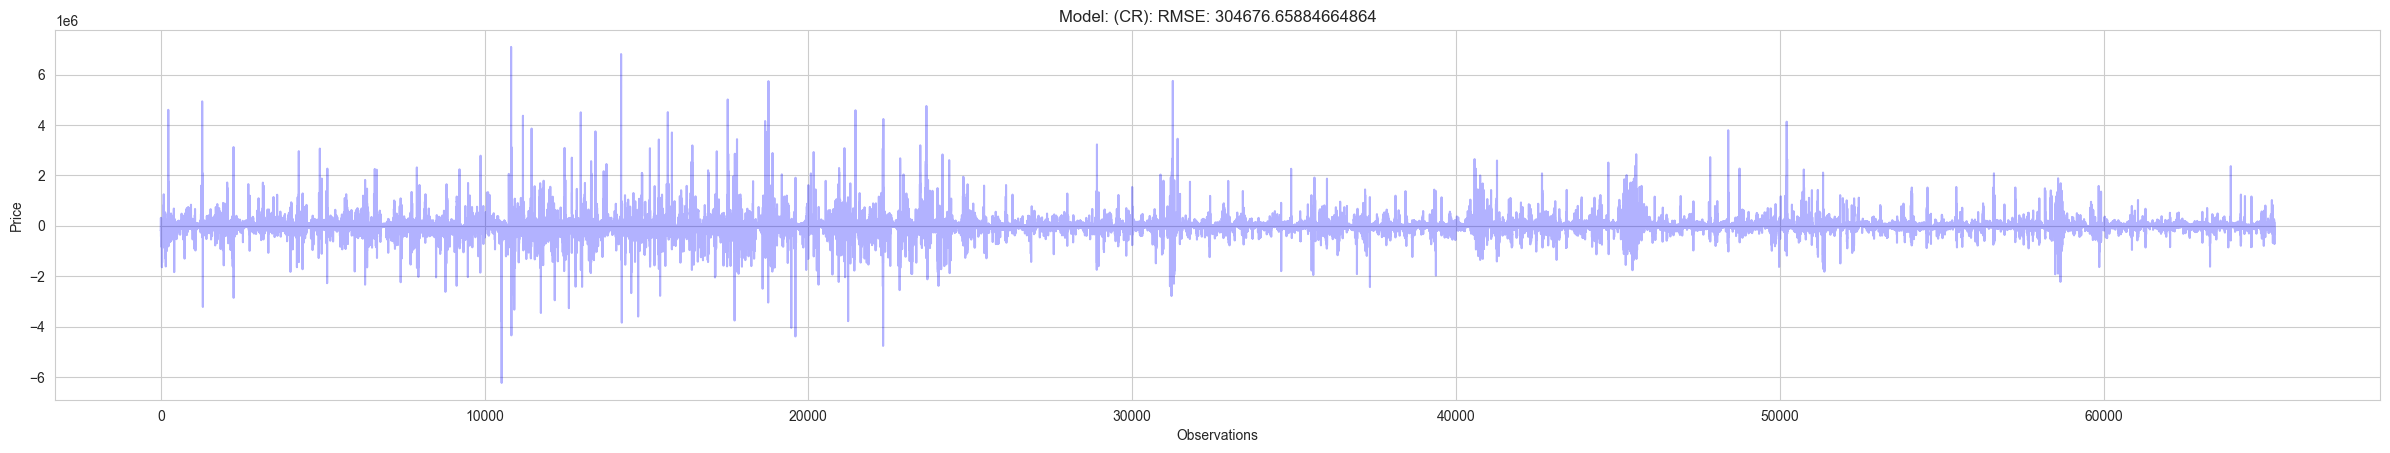

Predicting by CR...
Prediction done!


In [52]:
preds_cr = predict_with_model("CR")

### Making submission CSV

In [98]:
predDf = pd.DataFrame(
    {
        "property_key": test["property_key"],
        "contractDate": test["date"],
        "prediction": list(preds_lgbm)
    }
)

predDf.to_csv("submission.csv", index=False)